In [1]:
from commonroad.common.file_reader import CommonRoadFileReader
from python_scripts.simulation import step_simulation
from python_scripts.visualizer import Visualizer
import yaml
import matplotlib.pyplot as plt
from matplotlib import animation

def plot(time_step, ego_vehicle, scenarios, sensor_views):
    plt.cla()
    Visualizer().plot(scenario=scenarios[time_step],
                  sensor_view=sensor_views[time_step],
                  ego_vehicle=scenarios[time_step].obstacle_by_id(ego_vehicle.obstacle_id),
                  time_begin=time_step)
    plt.axis('scaled')
    plt.xlim(-70,70)
    plt.ylim(-10,130)

def plot_result_scenario(time_step, ego_vehicle, scenarios, sensor_views):
    plt.cla()
    Visualizer().plot(scenario=scenarios[time_step],
                  sensor_view=sensor_views[time_step],
                  ego_vehicle=scenarios[time_step].obstacle_by_id(ego_vehicle.obstacle_id),
                  time_begin=time_step)
    plt.axis('scaled')
    plt.xlim(0,270)
    plt.ylim(-5, 10)

# Simulate Single scenario

In [2]:
scenario_path = "scenarios/ZAM_trafficjam-1_1_T-1"
results_folder = "results/"


#======================================================#
with open(scenario_path + ".yaml") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

scenario1, _ = CommonRoadFileReader(scenario_path + ".xml").open()
scenario2, _ = CommonRoadFileReader(scenario_path + ".xml").open()

config['occlusion_params']['velocity_tracking_enabled'] = False
config['occlusion_params']['velocity_tracking_enabled'] = False
results_aware = step_simulation(scenario1, config)

config['occlusion_params']['ideal_tracking_enabled'] = True
config['occlusion_params']['velocity_tracking_enabled'] = True
results_unaware = step_simulation(scenario2, config, occlusion_aware = False)

In step 0


In step 1


In step 2


In step 3


In step 4


In step 5


In step 6


In step 7


In step 8


In step 9


In step 10


In step 11


In step 12


In step 13


In step 14


In step 15


In step 16


In step 17


In step 18


In step 19


In step 20


In step 21


In step 22


In step 23
In step 24


In step 25


In step 26


In step 27


In step 28


In step 29


In step 30


In step 31


In step 32


In step 33


In step 34


In step 35


In step 36


In step 37


In step 38


In step 39


In step 40


In step 41


In step 42


In step 43


In step 44


In step 45


In step 46


In step 47


In step 48


In step 49


In step 50


In step 51


In step 52


In step 53


In step 54


In step 55


In step 56


In step 57


In step 58


In step 59


In step 60


In step 61


In step 62


In step 63


In step 64


In step 65


In step 66


In step 67


In step 68


In step 69


In step 70


In step 0


In step 1


In step 2


In step 3
In step 4


In step 5
In step 6


In step 7


In step 8


In step 9


In step 10


In step 11


In step 12


In step 13


In step 14


In step 15


In step 16


In step 17


In step 18


In step 19


In step 20


In step 21


In step 22


In step 23


In step 24


In step 25


ZAM_trafficjam-1_1_T-1:  37%|███▋      | 26/71 [00:06<00:09,  4.68it/s]


In step 26


ZAM_trafficjam-1_1_T-1:  38%|███▊      | 27/71 [00:06<00:09,  4.76it/s]


In step 27


ZAM_trafficjam-1_1_T-1:  39%|███▉      | 28/71 [00:06<00:08,  4.81it/s]


In step 28


ZAM_trafficjam-1_1_T-1:  41%|████      | 29/71 [00:06<00:08,  4.83it/s]


In step 29


ZAM_trafficjam-1_1_T-1:  42%|████▏     | 30/71 [00:07<00:08,  4.87it/s]

In step 30


In step 31


In step 32


In step 33


In step 34


ZAM_trafficjam-1_1_T-1:  49%|████▉     | 35/71 [00:08<00:08,  4.29it/s]

In step 35
In step 36


In step 37
In step 38


In step 39


In step 40


In step 41


In step 42


In step 43


In step 44


In step 45


In step 46


In step 47


In step 48


In step 49


In step 50


In step 51


In step 52


In step 53


In step 54


In step 55


In step 56


In step 57


In step 58


In step 59


In step 60


In step 61


In step 62


In step 63


In step 64


In step 65


In step 66


In step 67


In step 68
In step 69


In step 70


# Visualise

In [ ]:
for shadow in tracked_shadows:
    Visualizer().plot_3D_shadows(shadow, 15,3)

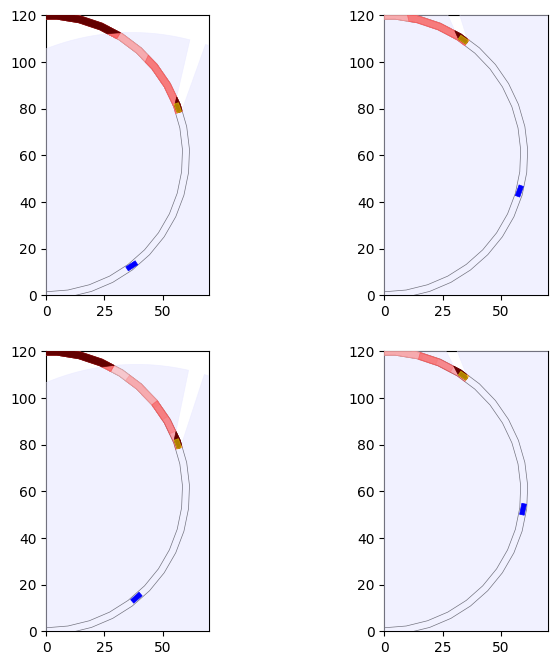

In [32]:
t1 = 15
t2 = 30
fig, ax = plt.subplots(2, 2, figsize=(20,13))
plt.sca(ax[0][0])
plot(t1, no_track_vehicle, not_tracked_scenarios, not_tracked_views)
plt.sca(ax[0][1])
plot(t2, no_track_vehicle, not_tracked_scenarios, not_tracked_views)
plt.sca(ax[1][0])
plot(t1, track_vehicle, tracked_scenarios, tracked_views)
plt.sca(ax[1][1])
plot(t2, track_vehicle, tracked_scenarios, tracked_views)

### Animation of the proposed method

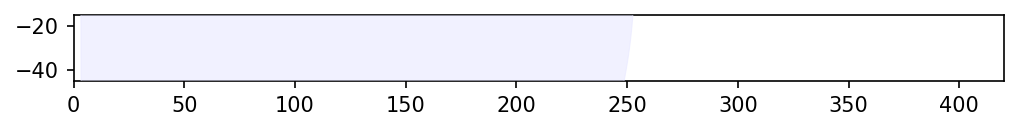

In [4]:
from IPython.display import HTML

fig = plt.figure(figsize=(12, 2), dpi=150)
anim = animation.FuncAnimation(fig,
                               plot_result_scenario, 
                               fargs=[results_unaware[0], results_unaware[1], results_unaware[2]], 
                               frames = range(config["simulation_duration"]), 
                               interval = 100, 
                               blit = False)
HTML(anim.to_html5_video())

### Velocity comparison

Text(0, 0.5, 'RSS distance [m]')

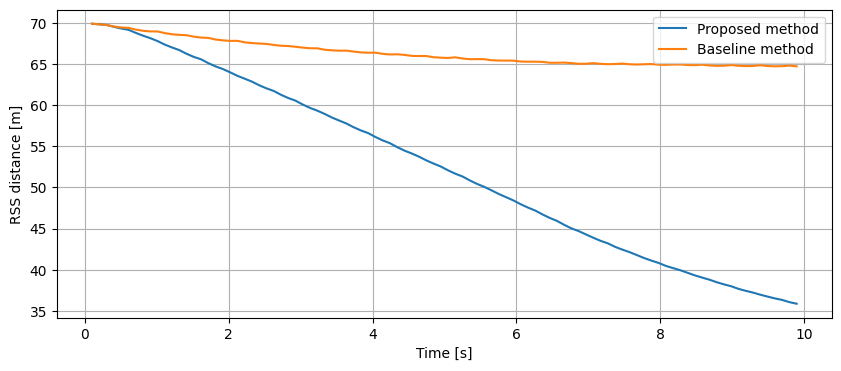

In [34]:
from utilities import find_RSS_distance
import numpy as np

dists_track = find_RSS_distance(track_vehicle, scenario1, config)
dists_no_track = find_RSS_distance(no_track_vehicle, scenario2, config)
time = np.linspace(0.1, config.get('simulation_duration')/10, config.get('simulation_duration')-1) #assuming dt = 0.1

plt.figure(figsize=(10,4))
labels = ['Proposed method','Baseline method']

plt.plot(time, dists_track, label=labels[0])
plt.plot(time, dists_no_track, label=labels[1])
plt.legend()
plt.grid()

plt.xlabel('Time [s]')
plt.ylabel('RSS distance [m]')

(22.0, 32.0)

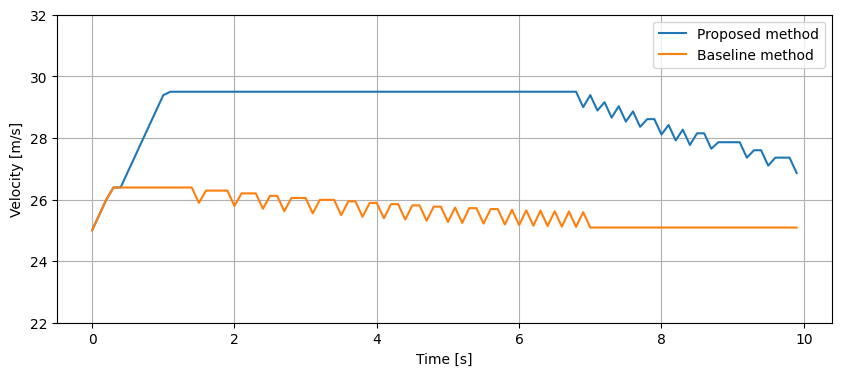

In [35]:
plt.figure(figsize=(10, 4))
labels = ['Proposed method','Baseline method']
for idx, vehicle in enumerate([track_vehicle, no_track_vehicle]):
    velocities = [round(vehicle.initial_state.velocity, 2)]
    time = [round(vehicle.initial_state.time_step/10, 2)]
    for state in vehicle.prediction.trajectory.state_list:
        velocities.append(round(state.velocity, 2))
        time.append(round(state.time_step/10, 2))
    plt.plot(time, velocities, label=labels[idx])
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid()
plt.ylim(22, 32)